In [267]:
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

import numpy as np
import os 

from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import numpy as np
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.smoother import ConvolutionSmoother

In [268]:
def getParentPath():
    path = os.getcwd()
    parent = os.path.join(path, os.pardir)
    absparent = os.path.abspath(parent)
    return absparent

def plotsmth(df, colX, colY, yearConfig):
    fig, ax = plt.subplots()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    if yearConfig==1:
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    else:
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_title(colY)
    ax.plot(df['{0}'.format(colX)], df['{0}'.format(colY)])
    plt.gcf().autofmt_xdate()

In [269]:
coin = 'polkadot'
pathToDf = '{0}\CryptoBehavior\Top 100 Crypto Coins\{1}.csv'.format(getParentPath(), coin)
dfCoin = pd.read_csv(pathToDf)

# prepare path for plots
pathToPlots = '{0}\Plots\{1}'.format(getParentPath(), coin)
if not os.path.exists(pathToPlots):
    os.makedirs(pathToPlots)

# set Date to datetime format
dfCoin.Date = pd.to_datetime(dfCoin.Date, format='%Y-%m-%d')

# show head
print(dfCoin.head())

        Date   Open   High    Low  Close   Volume Currency
0 2020-08-21  2.909  3.078  2.909  3.078  1066769      USD
1 2020-08-22  3.078  4.464  2.970  4.464  4020158      USD
2 2020-08-23  4.451  4.451  3.915  3.977  1560250      USD
3 2020-08-24  3.977  4.730  3.977  4.594  1559675      USD
4 2020-08-25  4.595  5.550  4.595  5.550  3024350      USD


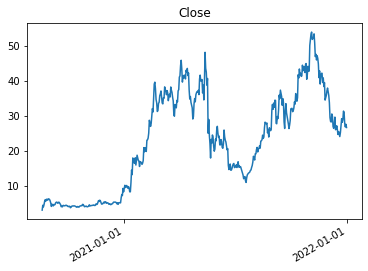

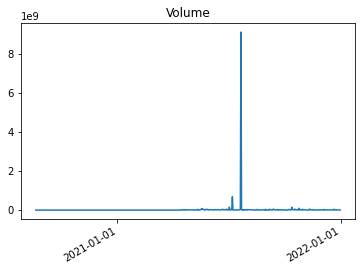

In [270]:
# plot all data
for colV in ['Close', 'Volume']:
    plotsmth(dfCoin, 'Date', colV, 1)

In [271]:
# set datesStart
dateStart = '2021-01-01'
dfCoinAnalyze = dfCoin.query('Date>"{0}"'.format(dateStart)).reset_index()

# plot remaining data
for colV in ['Close', 'Volume']:
    plotsmth(dfCoinAnalyze, 'Date', colV, 0)
    plt.savefig('{0}\{1}_plain.png'.format(pathToPlots, colV))
    plt.close()

In [272]:
# prepare data for breakpoint analysis
yClose = np.array(dfCoinAnalyze['Close'].tolist())
yVolume = np.array(dfCoinAnalyze['Volume'].tolist())
yDict = {'Close':yClose, 'Volume': yVolume}

# set number of breaks 
n_breaks = 5 

# Breakpoint dict 
breaksDict = {}

In [273]:
algor = 'Pelt'
for key in yDict:
    y = yDict[key]
    # detection by Pelt algorithm
    algo = rpt.Pelt(model="rbf").fit(y)
    result = algo.predict(pen=10)
    
    breaks_rpt = []
    for i in result:
        breaks_rpt.append(str(dfCoinAnalyze.Date[i-1].date()))
        
    case = '{0}_{1}'.format(algor, key)
    breaksDict[case] = breaks_rpt
    
    print('Break days by {2} algo for parameter {0} are {1}'.format(key, breaks_rpt, algor))
    # display
    fig,ax = rpt.display(y, result)
    ax[0].set_title(key)
    plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, key, algor))
    plt.close()

Break days by Pelt algo for parameter Close are ['2021-02-10', '2021-05-21', '2021-08-19', '2021-10-13', '2021-12-02', '2021-12-31']
Break days by Pelt algo for parameter Volume are ['2021-04-16', '2021-12-31']


In [274]:
algor = 'Dynp'
for key in yDict:
    y = yDict[key]
    
    # detection by Dynp algorithm
    model = rpt.Dynp(model="l1")
    model.fit(y)
    breaks = model.predict(n_bkps=n_breaks-1)
    
    breaks_rpt = []
    for i in breaks:
        breaks_rpt.append(str(dfCoinAnalyze.Date[i-1].date()))
        
    case = '{0}_{1}'.format(algor, key)
    breaksDict[case] = breaks_rpt
    
    print('Break days by {2} algo for parameter {0} are {1}'.format(key, breaks_rpt, algor))
    fig,ax = rpt.display(y, breaks)
    ax[0].set_title(key)
    plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, key, algor))
    plt.close()

Break days by Dynp algo for parameter Close are ['2021-02-10', '2021-05-21', '2021-08-29', '2021-12-02', '2021-12-31']
Break days by Dynp algo for parameter Volume are ['2021-04-16', '2021-05-11', '2021-06-05', '2021-11-02', '2021-12-31']


In [275]:
# as Dynp (Dynamic Programmin algo uses user-set number of breakpoints, I would use Pelt's results for analysis)

# Decomposition 

In [276]:
algor = 'Decompose'
ts_decomp = dfCoinAnalyze[['Date','Close']]
ts_decomp = ts_decomp.reset_index(drop=True)
ts_decomp = ts_decomp.set_index('Date')

ts_decomposed = seasonal_decompose(ts_decomp,model='multiplicative',extrapolate_trend=True)
ts_trend = ts_decomposed.trend
ts_seasonal = ts_decomposed.seasonal
ts_residual = ts_decomposed.resid
fig = ts_decomposed.plot()
fig.set_size_inches(11,8)
plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, key, algor))
plt.close()

# FBprophet btc analysis

In [277]:
algor = 'fbPro'

df = dfCoinAnalyze[['Date', 'Close']]
df = df.rename({'Date':'ds', 'Close':'y'}, axis='columns')

model = Prophet()
model.fit(df)
fcst = model.predict(df)
fig=model.plot_components(fcst)
plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, key, algor))
plt.close()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# tsmoothie

In [278]:
algor = 'tsmoothie'
for keys in yDict:
    # operate smoothing
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
    smoother.smooth(dfCoinAnalyze[['{0}'.format(keys)]])
    
    # generate intervals
    low, up = smoother.get_intervals('prediction_interval')
    
    # plot the smoothed timeseries with intervals
    plt.figure(figsize=(18,5))
    
    i = 0
    
    plt.plot(smoother.smooth_data[i], linewidth=3, color='blue')
    plt.plot(smoother.data[i], '.k')
    plt.title(f"timeseries {i+1}"); plt.xlabel('time'); plt.title(keys)
    
    plt.fill_between(range(len(smoother.data[i])), low[i], up[i], alpha=0.3)
    
    plt.plot(dfCoinAnalyze[['{0}'.format(keys)]])
    plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, keys, algor))
    plt.close()

In [279]:
algor = 'bootstrapping'
for keys in yDict:
    dfCoinTemp = BootstrappingWrapper(ConvolutionSmoother(window_len=8, window_type='ones'), 
                               bootstrap_type='mbb', block_length=24)
    dfCoinTemp_samples = dfCoinTemp.sample(dfCoinAnalyze[['{0}'.format(keys)]], n_samples=100)
    
    # plot the bootstrapped timeseries
    plt.figure(figsize=(13,5)); plt.title(keys)
    plt.plot(dfCoinTemp_samples.T, alpha=0.3, c='orange')
    plt.plot(dfCoinAnalyze[['{0}'.format(keys)]], c='blue', linewidth=2)
    plt.savefig('{0}\{1}_{2}.png'.format(pathToPlots, keys, algor))
    plt.close()

In [280]:
# create df of breakpoints from dict
dfBreaksFin = pd.DataFrame.from_dict(breaksDict, orient='index')\
                          .reset_index()\
                          .melt(id_vars='index')
dfBreaksFin = dfBreaksFin.drop(labels='variable', axis='columns')

# clean if needed
for x in dfBreaksFin['index'].unique():
    if 'object' in x:
        dfBreaksFin = dfBreaksFin.query('index!="{0}"'.format(x))
        break
dfBreaksFin = dfBreaksFin.sort_values(by='index')
print(dfBreaksFin['index'].unique())

# print df
print(dfBreaksFin)

# save df
dfBreaksFin.to_csv('{0}\Breakpoints.csv'.format(pathToPlots))

['Dynp_Close' 'Dynp_Volume' 'Pelt_Close' 'Pelt_Volume']
          index       value
2    Dynp_Close  2021-02-10
18   Dynp_Close  2021-12-31
14   Dynp_Close  2021-12-02
6    Dynp_Close  2021-05-21
22   Dynp_Close        None
10   Dynp_Close  2021-08-29
11  Dynp_Volume  2021-06-05
19  Dynp_Volume  2021-12-31
15  Dynp_Volume  2021-11-02
23  Dynp_Volume        None
7   Dynp_Volume  2021-05-11
3   Dynp_Volume  2021-04-16
8    Pelt_Close  2021-08-19
12   Pelt_Close  2021-10-13
4    Pelt_Close  2021-05-21
16   Pelt_Close  2021-12-02
20   Pelt_Close  2021-12-31
0    Pelt_Close  2021-02-10
13  Pelt_Volume        None
5   Pelt_Volume  2021-12-31
17  Pelt_Volume        None
1   Pelt_Volume  2021-04-16
21  Pelt_Volume        None
9   Pelt_Volume        None
